In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('ydd.csv')
x = df['IE WindA']
y = df['IE WindB']

u = np.array(x)
y = np.array(y)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# 初始化 MinMaxScaler，将数据缩放到 [0, 1]
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# 对 x 和 y 进行归一化
x_normalized = scaler_x.fit_transform(u.reshape(-1, 1))
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))

# 打印归一化后的数据范围
print(f"x_normalized range: {x_normalized.min()} to {x_normalized.max()}")
print(f"y_normalized range: {y_normalized.min()} to {y_normalized.max()}")

x_normalized range: 0.0 to 1.0
y_normalized range: 0.0 to 1.0


In [4]:
def create_io_dataset(u, y, window_size):
    """
    u: 输入序列 (全部)
    y: 输出序列 (全部)
    window_size: LSTM 看过去多少个点
    """
    sequences = []
    targets = []
    
    # 因为我们需要过去的 window_size 个数据，所以从 window_size 开始遍历
    for i in range(len(u) - window_size):
        # 输入特征: 截取 u 的一段 [i : i+window]
        seq = u[i:i+window_size]
        # 目标标签: 对应的 y 值，通常对应这段窗口结束时的 y
        label = y[i+window_size]
        
        sequences.append(seq)
        targets.append(label)
        
    return np.array(sequences), np.array(targets)

window_size = 20  # 观察过去 20 个时间步 (即 20 * 0.2s = 4秒的历史)

# 制作数据集
X, y = create_io_dataset(x_normalized, y_normalized, window_size)

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 划分训练集和测试集 (80% 训练, 20% 测试)
train_split = int(len(X) * 0.8)

X_train = torch.from_numpy(X[:train_split]).float()  # shape: (样本数, window, 1)
y_train = torch.from_numpy(y[:train_split]).float()  # shape: (样本数, 1)
X_test = torch.from_numpy(X[train_split:]).float()
y_test = torch.from_numpy(y[train_split:]).float()  

# 使用 DataLoader (避免内存爆炸)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [6]:
import torch.nn as nn

class myLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=5, output_size=1):
        super(myLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]    # 取最后一个时间步的输出
        out = self.fc(out)     # 全连接层
        return out
    
model = myLSTM(input_size=1, hidden_size=50, num_layers=5, output_size=1)

In [7]:
# --------------------------
# 4. 训练 (Training)
# --------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 200
print("开始拟合 U -> Y 的映射关系...")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # 每个 epoch 打印平均损失
    print(f'Epoch [{epoch+1}/{epochs}], Avg Loss: {total_loss/len(train_loader):.6f}')

开始拟合 U -> Y 的映射关系...
Epoch [1/200], Avg Loss: 0.013048
Epoch [2/200], Avg Loss: 0.008479
Epoch [3/200], Avg Loss: 0.008291
Epoch [4/200], Avg Loss: 0.008111
Epoch [5/200], Avg Loss: 0.007983
Epoch [6/200], Avg Loss: 0.007777
Epoch [7/200], Avg Loss: 0.007752
Epoch [8/200], Avg Loss: 0.007645
Epoch [9/200], Avg Loss: 0.007465
Epoch [10/200], Avg Loss: 0.007261
Epoch [11/200], Avg Loss: 0.007105
Epoch [12/200], Avg Loss: 0.006845
Epoch [13/200], Avg Loss: 0.006673
Epoch [14/200], Avg Loss: 0.006390
Epoch [15/200], Avg Loss: 0.006134
Epoch [16/200], Avg Loss: 0.005784
Epoch [17/200], Avg Loss: 0.005523
Epoch [18/200], Avg Loss: 0.005080
Epoch [19/200], Avg Loss: 0.004574
Epoch [20/200], Avg Loss: 0.004228
Epoch [21/200], Avg Loss: 0.003846
Epoch [22/200], Avg Loss: 0.003454
Epoch [23/200], Avg Loss: 0.003145
Epoch [24/200], Avg Loss: 0.002922
Epoch [25/200], Avg Loss: 0.002527
Epoch [26/200], Avg Loss: 0.002310
Epoch [27/200], Avg Loss: 0.002148
Epoch [28/200], Avg Loss: 0.001936
Epoch [2

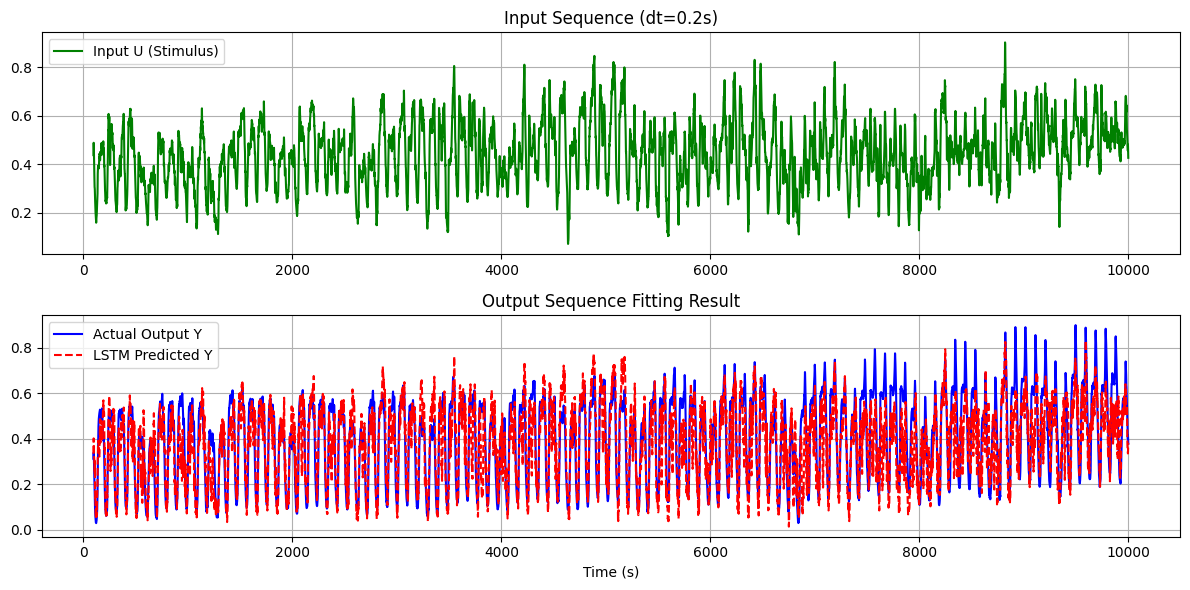

In [15]:
import matplotlib.pyplot as plt

# --------------------------
# 5. 验证与绘图 (Visualization)
# --------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# 转换回 numpy 用于绘图
y_true = y_test.numpy()
y_pred = predictions.numpy()
# 对应的时间轴 (切掉前面的 window_size 和 训练集部分)
t_test = np.arange(96,10000)

plt.figure(figsize=(12, 6))

# 子图1: 输入信号 U (展示给用户看在这个时间段输入了什么)
plt.subplot(2, 1, 1)
plt.plot(t_test, x_normalized[window_size + train_split:window_size + train_split + len(t_test)], color='green', label='Input U (Stimulus)')
plt.title(f'Input Sequence (dt=0.2s)')
plt.legend()
plt.grid(True)

# 子图2: 输出信号 Y (真实 vs 预测)
plt.subplot(2, 1, 2)
plt.plot(t_test, y_true[:len(t_test)], label='Actual Output Y', color='blue')
plt.plot(t_test, y_pred[:len(t_test)], label='LSTM Predicted Y', color='red', linestyle='--')
plt.title('Output Sequence Fitting Result')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt

x_all = torch.from_numpy(X).float()
y_all = torch.from_numpy(y).float()
# --------------------------
# 5. 验证与绘图 (Visualization)
# --------------------------
model.eval()
with torch.no_grad():
    predictions = model(x_all)

# 转换回 numpy 用于绘图
y_true = y_all.numpy()
y_pred = predictions.numpy()
# 对应的时间轴 (切掉前面的 window_size 和 训练集部分)
t_test = t[window_size:]

plt.figure(figsize=(12, 6))

# 子图1: 输入信号 U (展示给用户看在这个时间段输入了什么)
plt.subplot(2, 1, 1)
plt.plot(t_test, u[window_size:], color='green', label='Input U (Stimulus)')
plt.title(f'Input Sequence (dt=0.2s)')
plt.legend()
plt.grid(True)

# 子图2: 输出信号 Y (真实 vs 预测)
plt.subplot(2, 1, 2)
plt.plot(t_test, y_true, label='Actual Output Y', color='blue')
plt.plot(t_test, y_pred, label='LSTM Predicted Y', color='red', linestyle='--')
plt.title('Output Sequence Fitting Result')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 't' is not defined

In [18]:
import sklearn.metrics as metrics

# 计算均方误差 (MSE)
mse = metrics.mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE) on Test Set: {mse:.6f}')
# 计算RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.6f}')


Mean Squared Error (MSE) on Test Set: 0.014744
Root Mean Squared Error (RMSE) on Test Set: 0.121423


In [ ]:
torch.save(model, 'complete_model.pt')